# **License Plate Detection and Recognition**

In [1]:
#Initial imports
import os
import re
import cv2
import time
import argparse
import numpy as np
from glob import glob
import seaborn as sns
from PIL import Image
import  xml.dom.minidom
from pathlib import Path
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

In [2]:
#mounting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#unzipping the contents of the dataset folder
!unzip /content/drive/MyDrive/capstone*.zip -d /content/drive/MyDrive/capstone


Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/capstone1/voc_plate_dataset/JPEGImages/CarLongPlateGen2838.jpg  
  inflating: /content/drive/MyDrive/capstone1/voc_plate_dataset/JPEGImages/CarLongPlateGen2839.jpg  
  inflating: /content/drive/MyDrive/capstone1/voc_plate_dataset/JPEGImages/CarLongPlateGen284.jpg  
  inflating: /content/drive/MyDrive/capstone1/voc_plate_dataset/JPEGImages/CarLongPlateGen2840.jpg  
  inflating: /content/drive/MyDrive/capstone1/voc_plate_dataset/JPEGImages/CarLongPlateGen2841.jpg  
  inflating: /content/drive/MyDrive/capstone1/voc_plate_dataset/JPEGImages/CarLongPlateGen2842.jpg  
  inflating: /content/drive/MyDrive/capstone1/voc_plate_dataset/JPEGImages/CarLongPlateGen2843.jpg  
  inflating: /content/drive/MyDrive/capstone1/voc_plate_dataset/JPEGImages/CarLongPlateGen2844.jpg  
  inflating: /content/drive/MyDrive/capstone1/voc_plate_dataset/JPEGImages/CarLongPlateGen2845.jpg  
  inflating: /content/drive/MyDrive/capst

In [4]:
#Checking the number of images in the file
import os
onlyfiles = next(os.walk("/content/drive/MyDrive/capstone/voc_plate_dataset/JPEGImages"))[2]
print(len(onlyfiles))

8298


In [5]:
#checking the number of annotations in the file
onlyfiles = next(os.walk("/content/drive/MyDrive/capstone/voc_plate_dataset/Annotations"))[2]
print(len(onlyfiles))

8298


In [6]:
#checking the contents of the folder
dir_images = "/content/drive/MyDrive/capstone/voc_plate_dataset/JPEGImages"
dir_bounding = "/content/drive/MyDrive/capstone/voc_plate_dataset/Annotations"

#length of Images
all_files = glob(dir_images+ "/*")
print("Number of files in JPEGImage directory: ",len(all_files))

#length of Annotations
all_annotations = glob(dir_bounding+ "/*")
print("Number of files in Annotations directory: ",len(all_annotations))

#assigning
test_img = all_files[0]
test_annotation = all_annotations[0]

#printing test image and annotation
print("test_img: ",test_img)
print("test_annotation: ",test_annotation)

#fetching file name for images
last_name = test_img.split("/")[-1]
name = last_name.split(".")[0]
print("file name for images: ",name)

#fetching file name for annotation
last_name = test_annotation.split("/")[-1]
name = last_name.split(".")[0]
print("file name for annotations: ",name)


#sorting image files 
final_images = []
for i in all_files:
  last_name = i.split("/")[-1]
  name = last_name.split(".")[0]
  final_images.append(name)
final_images.sort()

#sorting annotation files
final_annotations = []
for i in all_annotations:
  last_name = i.split("/")[-1]
  name = last_name.split(".")[0]
  final_annotations.append(name)
final_annotations.sort()
print("final_annotations: ",final_annotations[:5])

print("final_images: ",final_images[:5])

#appending images and annotations
final_data = []
for i in range(len(final_images)):
  for j in range(len(final_annotations)):
    if(final_images[i]==final_annotations[j].split('.')[0]):
      final_data.append(final_images[i])
      break

print("final_data: ",final_data[:10])


images = []
for i in final_data:
  images.append(cv2.imread(os.path.join(dir_images,i) + '.jpg'))
print("Number of images: ",len(images))

Number of files in JPEGImage directory:  8298
Number of files in Annotations directory:  8298
test_img:  /content/drive/MyDrive/capstone1/voc_plate_dataset/JPEGImages/boderngoaigiao0.jpg
test_annotation:  /content/drive/MyDrive/capstone1/voc_plate_dataset/Annotations/boderngoaigiao0.xml
file name for images:  boderngoaigiao0
file name for annotations:  boderngoaigiao0
final_annotations:  ['CarLongPlate0', 'CarLongPlate1', 'CarLongPlate10', 'CarLongPlate100', 'CarLongPlate101']
final_images:  ['CarLongPlate0', 'CarLongPlate1', 'CarLongPlate10', 'CarLongPlate100', 'CarLongPlate101']
final_data:  ['CarLongPlate0', 'CarLongPlate1', 'CarLongPlate10', 'CarLongPlate100', 'CarLongPlate101', 'CarLongPlate102', 'CarLongPlate103', 'CarLongPlate104', 'CarLongPlate105', 'CarLongPlate106']
Number of images:  8298


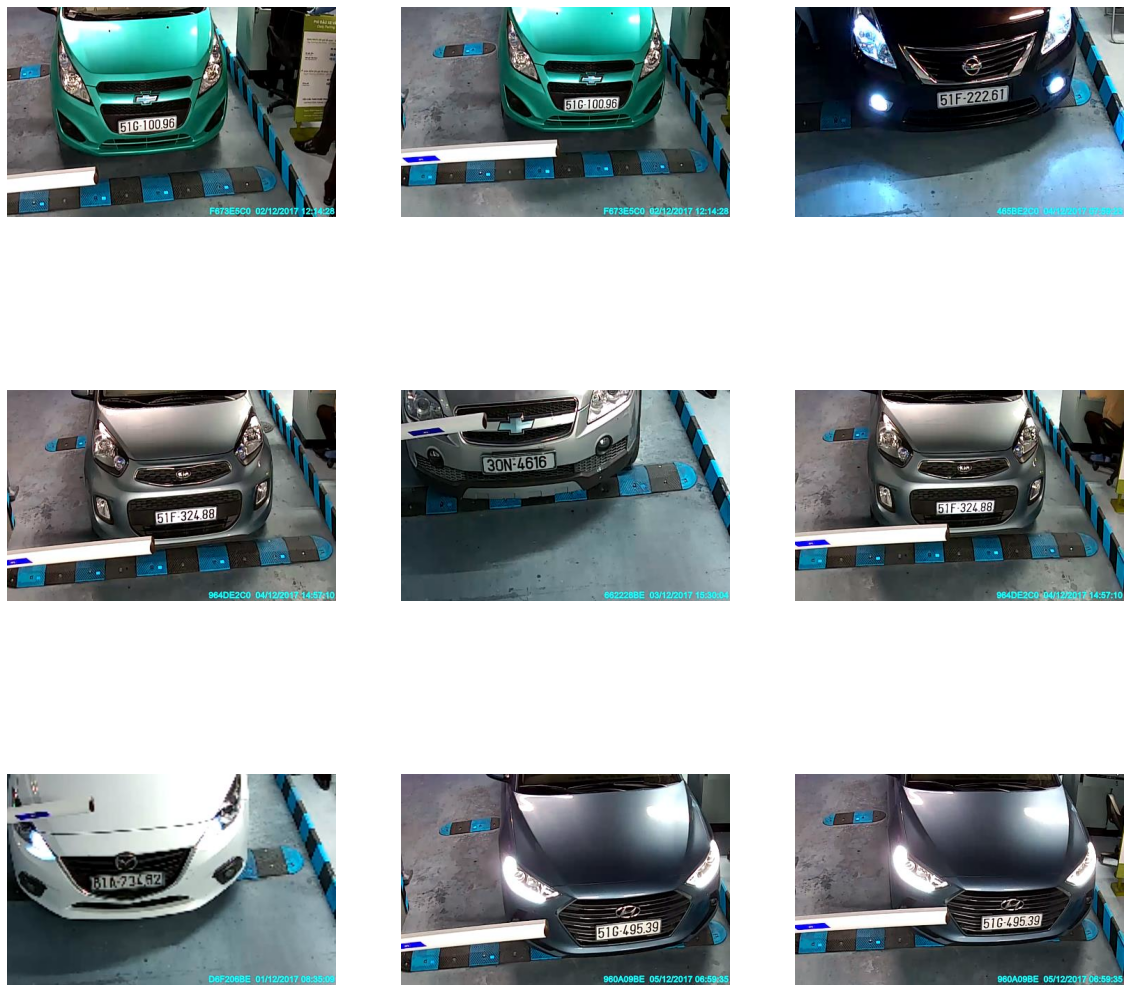

In [7]:
#Visualizing the images
plt.figure(figsize=(20,20))
for i in range(9):
 
  plt.subplot(3,3,i+1)
  plt.imshow(images[i])
  plt.axis("off")

In [8]:
#parsing 
def extract_boxes(filename):        
    # load and parse the file
    tree = ET.parse(filename)
    # get the root of the document
    root = tree.getroot()
    # extract each bounding box
    boxes = list()
    for box in root.findall('.//bndbox'):
        xmin = int(box.find('xmin').text)
        ymin = int(box.find('ymin').text)
        xmax = int(box.find('xmax').text)
        ymax = int(box.find('ymax').text)
        coors = [xmin, ymin, xmax, ymax]
        boxes.append(coors)
        
    # extract image dimensions
    width = int(root.find('.//size/width').text)
    height = int(root.find('.//size/height').text)
    return boxes, width, height

In [9]:
#Converting images to greyscale
#Grayscale is preferred for extracting descriptors instead of operating on color images directly because grayscale simplifies the algorithm and reduces computational requirements
import os,cv2
from google.colab.patches import cv2_imshow
path = r"/content/drive/MyDrive/capstone/voc_plate_dataset/JPEGImages" # Source Folder
dstpath = r"/content/drive/MyDrive/capstone/voc_plate_dataset/grayscale" # Destination Folder

try:
    os.makedirs(dstpath)
except:
    print ("Directory already exist, images will be written in same folder")

# Folder won't used
files = os.listdir(path)

for image in files:
    img = cv2.imread(os.path.join(path,image))
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    cv2.imwrite(os.path.join(dstpath,image),gray)  

In [10]:
#checking if all the images are set into grayscale
onlyfiles = next(os.walk("/content/drive/MyDrive/capstone/voc_plate_dataset/grayscale"))[2] 
print("Number of grayscale images : ",len(onlyfiles))

Number of grayscale images :  8298


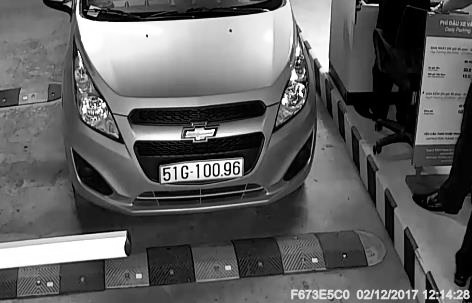

In [11]:
#displaying image
from PIL import Image
from google.colab.patches import cv2_imshow

im = cv2.imread("/content/drive/MyDrive/capstone/voc_plate_dataset/grayscale/CarLongPlate0.jpg")
cv2_imshow(im)

In [12]:
#Converting data in YOLO format
import xml.etree.ElementTree as ET
import glob
import os
import json

def xml_to_yolo_bbox(bbox, w, h):
    # xmin, ymin, xmax, ymax
    x_center = ((bbox[2] + bbox[0]) / 2) / w
    y_center = ((bbox[3] + bbox[1]) / 2) / h
    width = (bbox[2] - bbox[0]) / w
    height = (bbox[3] - bbox[1]) / h
    return [x_center, y_center, width, height]

def yolo_to_xml_bbox(bbox, w, h):
    # x_center, y_center width heigth
    w_half_len = (bbox[2] * w) / 2
    h_half_len = (bbox[3] * h) / 2
    xmin = int((bbox[0] * w) - w_half_len)
    ymin = int((bbox[1] * h) - h_half_len)
    xmax = int((bbox[0] * w) + w_half_len)
    ymax = int((bbox[1] * h) + h_half_len)
    return [xmin, ymin, xmax, ymax]


classes = []
input_dir = "/content/drive/MyDrive/capstone/voc_plate_dataset/Annotations"
output_dir = "/content/drive/MyDrive/capstone/voc_plate_dataset/labels"
image_dir = "/content/drive/MyDrive/capstone/voc_plate_dataset/grayscale"

# create the labels folder (output directory)
os.mkdir(output_dir)

# identify all the xml files in the annotations folder (input directory)
files = glob.glob(os.path.join(input_dir, '*.xml'))
# loop through each 
for fil in files:
    basename = os.path.basename(fil)
    filename = os.path.splitext(basename)[0]
    # check if the label contains the corresponding image file
    if not os.path.exists(os.path.join(image_dir, f"{filename}.jpg")):
        print(f"{filename} image does not exist!")
        continue

    result = []

    # parse the content of the xml file
    tree = ET.parse(fil)
    root = tree.getroot()
    width = int(root.find("size").find("width").text)
    height = int(root.find("size").find("height").text)

    for obj in root.findall('object'):
        label = obj.find("name").text
        # check for new classes and append to list
        if label not in classes:
            classes.append(label)
        index = classes.index(label)
        pil_bbox = [int(x.text) for x in obj.find("bndbox")]
        yolo_bbox = xml_to_yolo_bbox(pil_bbox, width, height)
        # convert data to string
        bbox_string = " ".join([str(x) for x in yolo_bbox])
        result.append(f"{index} {bbox_string}")

    if result:
        # generate a YOLO format text file for each xml file
        with open(os.path.join(output_dir, f"{filename}.txt"), "w", encoding="utf-8") as f:
            f.write("\n".join(result))

# generate the classes file as reference
with open('classes.txt', 'w', encoding='utf8') as f:
    f.write(json.dumps(classes))

In [14]:
#Splitting train and test data as per given indexes
with open('/content/drive/MyDrive/capstone/voc_plate_dataset/ImageSets/Main/test.txt') as f:
    lines = f.readlines()
test_lines = [x.split("\n")[0] for x in lines] 

with open('/content/drive/MyDrive/capstone/voc_plate_dataset/ImageSets/Main/trainval.txt') as f:
    lines = f.readlines()
train_lines = [x.split("\n")[0] for x in lines] 


print('Length of test',len(test_lines))
print('Length of train',len(train_lines))

os.mkdir("/content/drive/MyDrive/capstone/voc_plate_dataset/Dataset")
time.sleep(10)
os.mkdir("/content/drive/MyDrive/capstone/voc_plate_dataset/Dataset/Train")
time.sleep(5)
os.mkdir("/content/drive/MyDrive/capstone/voc_plate_dataset/Dataset/Test")
time.sleep(5)
os.mkdir("/content/drive/MyDrive/capstone/voc_plate_dataset/Dataset/Train/Images")
time.sleep(5)
os.mkdir("/content/drive/MyDrive/capstone/voc_plate_dataset/Dataset/Test/Images")
time.sleep(5)
os.mkdir("/content/drive/MyDrive/capstone/voc_plate_dataset/Dataset/Train/labels")
time.sleep(5)
os.mkdir("/content/drive/MyDrive/capstone/voc_plate_dataset/Dataset/Test/labels")
time.sleep(5)
src_dir = "/content/drive/MyDrive/capstone/voc_plate_dataset/grayscale"
new = os.listdir(src_dir)
new = [x.split(".")[0] for x in new]
len(new)

import glob
import shutil

test_dir = "/content/drive/MyDrive/capstone/voc_plate_dataset/Dataset/Test/Images"
for i in range(len(test_lines)):
  if test_lines[i] in new:
    new_path = src_dir +"/" +test_lines[i] + ".jpg"
    for jpgfile in glob.iglob(new_path):
        shutil.copy(jpgfile, test_dir)

print("Length of folders present in Test: ",len(os.listdir(test_dir)))
print("length of test images: ",len(test_lines))

train_dir = "/content/drive/MyDrive/capstone/voc_plate_dataset/Dataset/Train/Images"
for i in range(len(train_lines)):
  if train_lines[i] in new:
    new_path = src_dir +"/" +train_lines[i] + ".jpg"
    for jpgfile in glob.iglob(new_path):
      shutil.copy(jpgfile, train_dir)

print("Length of folders present in Train: ",len(os.listdir(train_dir)))
print("length of train images: ",len(train_lines))

srclabel_dir = "/content/drive/MyDrive/capstone/voc_plate_dataset/labels"
new = os.listdir(srclabel_dir)
new = [x.split(".")[0] for x in new]
len(new)

testlabel_dir = "/content/drive/MyDrive/capstone/voc_plate_dataset/Dataset/Test/labels"
for i in range(len(test_lines)):
  if test_lines[i] in new:
    new_path = srclabel_dir +"/" +test_lines[i] + ".txt"
    for txtfile in glob.iglob(new_path):
        shutil.copy(txtfile, testlabel_dir)

print("Length of labels present in Test: ",len(os.listdir(testlabel_dir)))
print("length of train labels: ",len(test_lines))

trainlabel_dir = "/content/drive/MyDrive/capstone/voc_plate_dataset/Dataset/Train/labels"
for i in range(len(train_lines)):
  if train_lines[i] in new:
    new_path = srclabel_dir +"/" +train_lines[i] + ".txt"
    for txtfile in glob.iglob(new_path):
        shutil.copy(txtfile, trainlabel_dir)

print("Length of labels present in Test: ",len(os.listdir(trainlabel_dir)))
print("length of train labels: ",len(train_lines))

Length of test 1501
Length of train 8298
Length of folders present in Test:  1501
length of test images:  1501
Length of folders present in Train:  8298
length of train images:  8298
Length of labels present in Test:  1501
length of train labels:  1501
Length of labels present in Test:  8298
length of train labels:  8298


#Training yolo v5 model

In [16]:
#cloning the official yolo git repo
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
#Installing the required libraries for yolo
%pip install -qr requirements.txt
import utils
display = utils.notebook_init()

INFO:yolov5:YOLOv5 🚀 v6.2-207-g54f49fa Python-3.7.15 torch-1.12.1+cu113 CPU
YOLOv5 🚀 v6.2-207-g54f49fa Python-3.7.15 torch-1.12.1+cu113 CPU


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 24.3/107.7 GB disk)


In [ ]:
# this is the YAML file 
%cat /content/drive/MyDrive/capstone/voc_plate_dataset/yolov5/data/yolo.yaml

path: /content/drive/MyDrive/capstone
train: /content/drive/MyDrive/capstone/voc_plate_dataset/Dataset/Train
val: /content/drive/MyDrive/capstone/voc_plate_dataset/Dataset/Test

nc: 1
names: ['plate']


In [18]:
#Define number of classes based on YAML
import yaml
with open("/content/yolo.yaml",'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [19]:
num_classes

'1'

In [20]:
#Model configuration 
%cat /content/drive/MyDrive/capstone/voc_plate_dataset/yolov5/models/yolov5m.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.67  # model depth multiple
width_multiple: 0.75  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [21]:
#Customizing iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [22]:
%%writetemplate /content/drive/MyDrive/capstone/voc_plate_dataset/yolov5/models/custom_yolov5m.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [26]:
%cat /content/drive/MyDrive/capstone/voc_plate_dataset/yolov5/models/custom_yolov5m.yaml


# parameters
nc: 1  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-

#Training Custom YOLOv5 Detector
**Number of arguments:**

**img**: define input image size

**batch**: determine batch size

**epochs**: define the number of training epochs

**data**: set the path to our yaml file

**cfg**: specify our model configuration

**weights**: specify a custom path to weights.

**name**: result names

**nosave**: only save the final checkpoint

**cache**: cache images for faster training



In [ ]:
# train yolov5s on custom data for 50 epochs
# time its performance
%%time
%cd /content/drive/MyDrive/capstone/voc_plate_dataset/yolov5
!python train.py --img 416 --batch 32 --epochs 50 --data '/content/drive/MyDrive/capstone/voc_plate_dataset/yolov5/data/yolo.yaml' --cfg ./models/custom_yolov5m.yaml --weights '' --name yolov5s_results  --cache

/content/drive/MyDrive/capstone/voc_plate_dataset/yolov5
train: weights=, cfg=./models/custom_yolov5m.yaml, data=/content/drive/MyDrive/capstone/voc_plate_dataset/yolov5/data/yolo.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=32, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-203-g6371de8 Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, 

#Evaluating Custom YOLOv5 Detector Performance

In [ ]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
%load_ext tensorboard
%tensorboard --logdir runs

GROUND TRUTH TRAINING DATA:


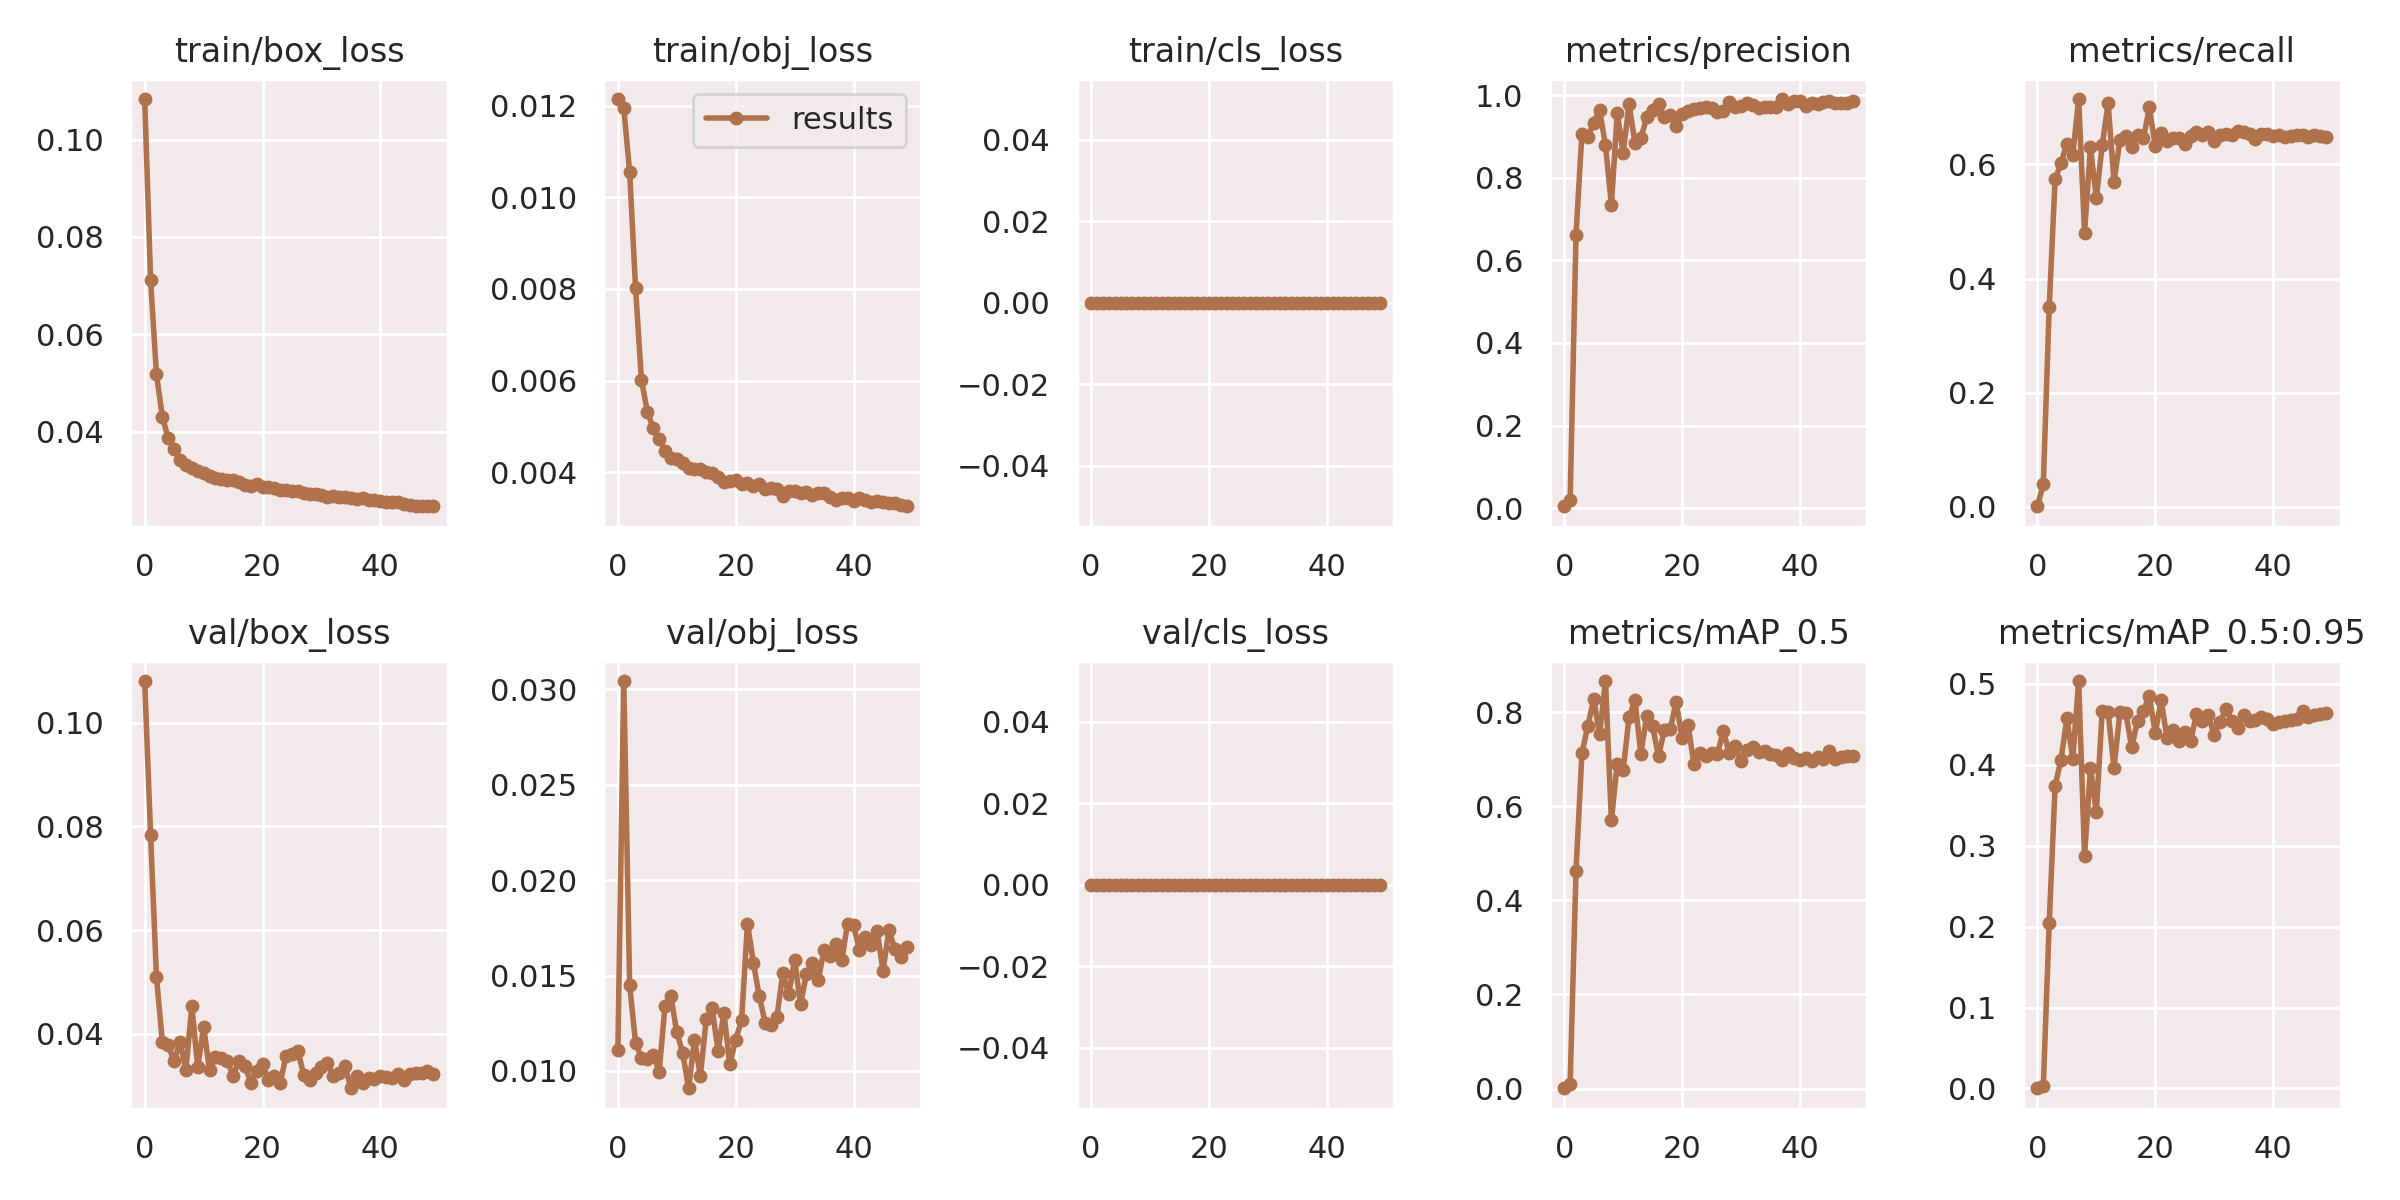

In [ ]:
from skimage import io 
from google.colab.patches import cv2_imshow

print("GROUND TRUTH TRAINING DATA:")
img_path= "/content/drive/MyDrive/capstone/voc_plate_dataset/yolov5/runs/train/yolov5s_results4/results.png"
image= io.imread(img_path)
cv2_imshow(image)

#Visualizing Training Data

Ground truth training data:


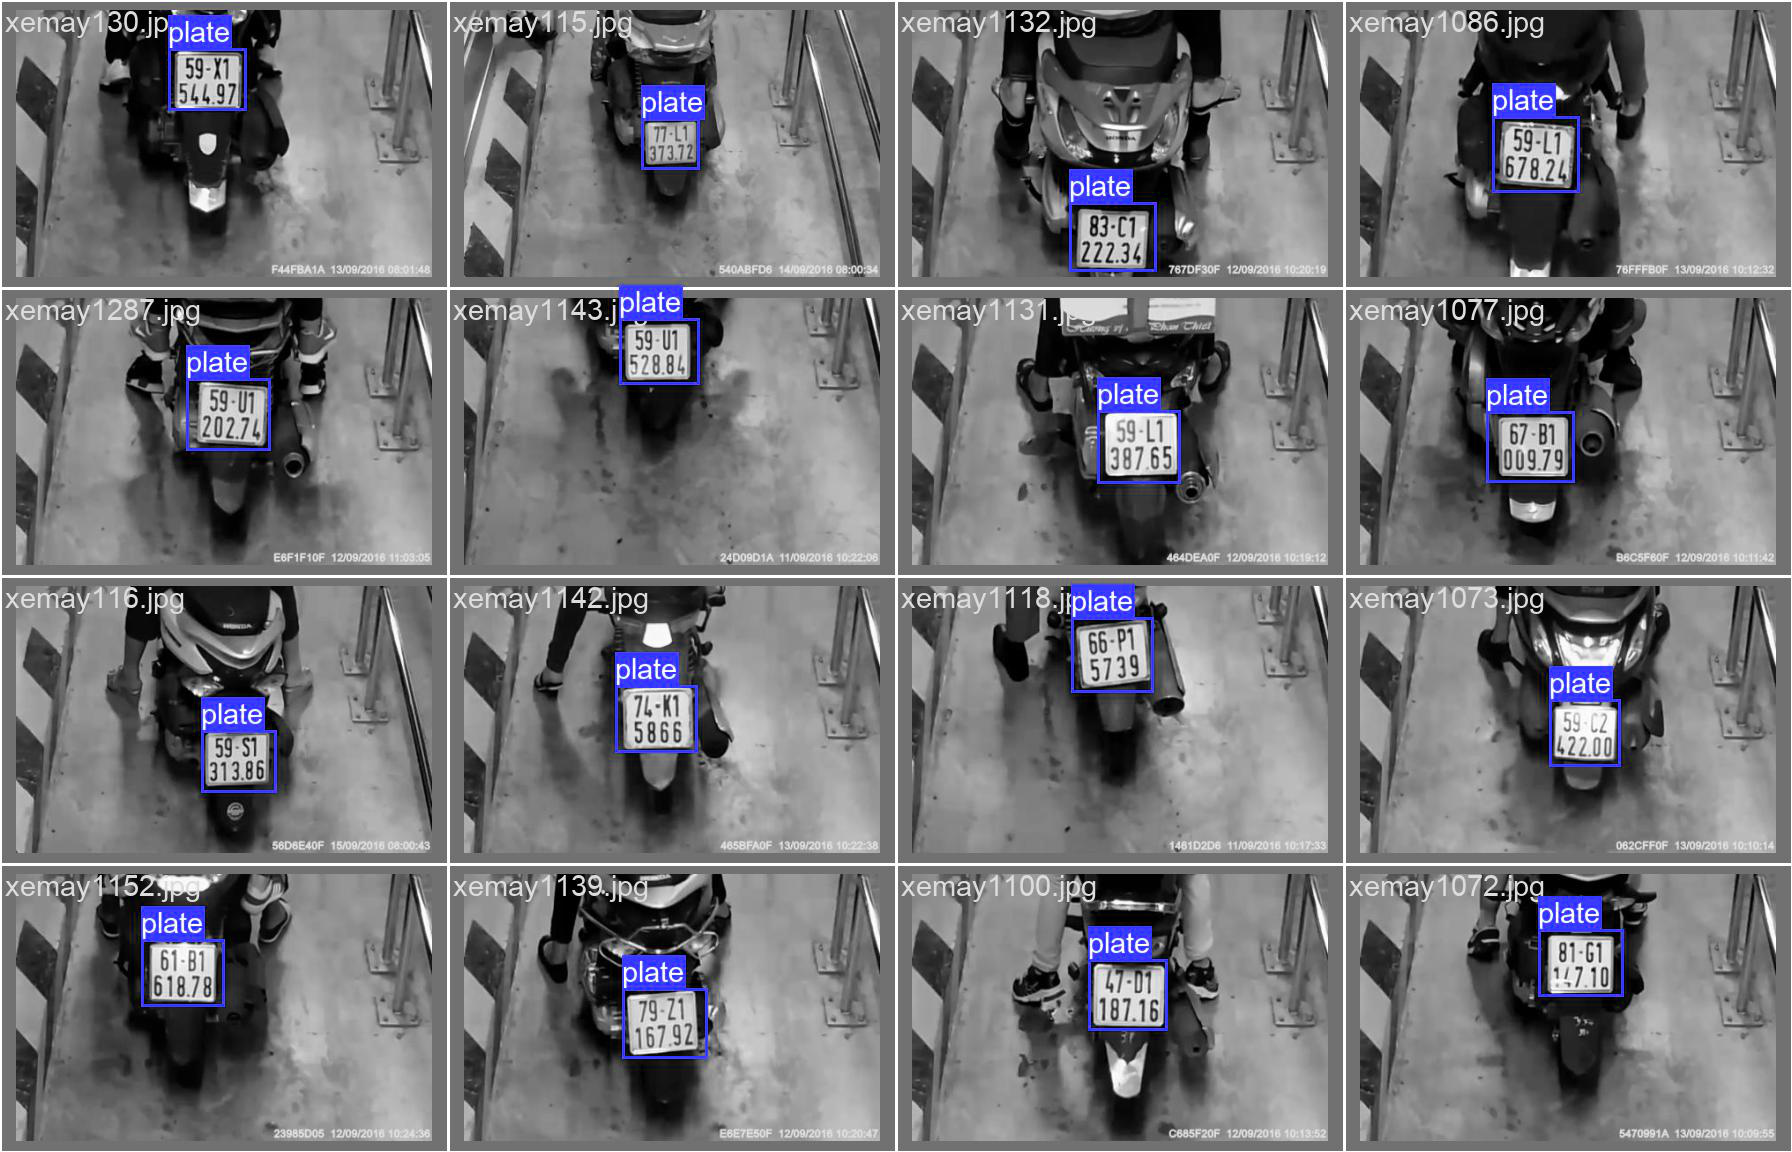

In [ ]:
#display our ground truth data

from skimage import io 
from google.colab.patches import cv2_imshow

print("Ground truth training data:")
img_path='/content/drive/MyDrive/capstone/voc_plate_dataset/yolov5/runs/train/yolov5s_results4/val_batch2_labels.jpg'
#"/content/yolov5/runs/train/yolov5s_results/val_batch2_labels.jpg"
image= io.imread(img_path)
cv2_imshow(image)

Predicted label data:


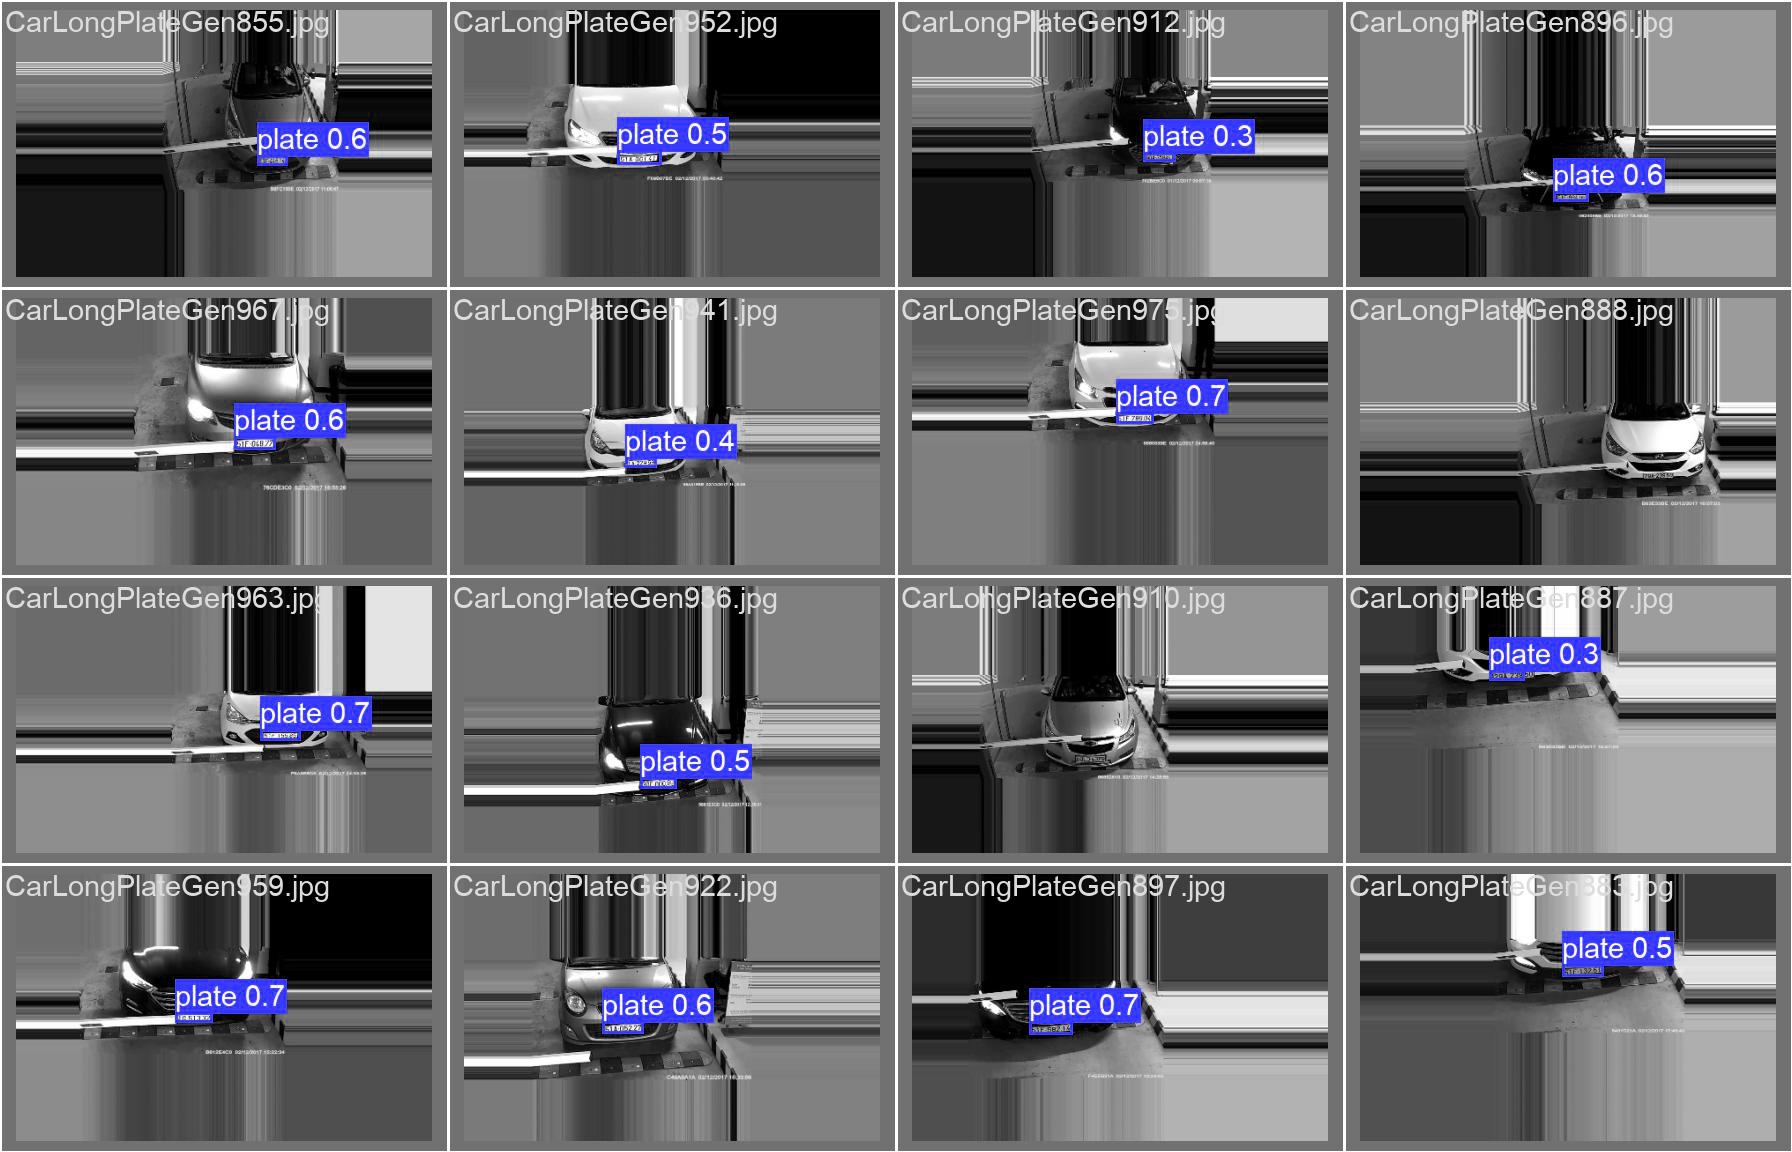

In [ ]:
#Predicted Label Data

from skimage import io 
from google.colab.patches import cv2_imshow

print("Predicted label data:")
img_path= "/content/drive/MyDrive/capstone/voc_plate_dataset/yolov5/runs/train/yolov5s_results4/val_batch1_pred.jpg"
image= io.imread(img_path)
cv2_imshow(image)

#Augmented Training Example

In [ ]:
from skimage import io 
from google.colab.patches import cv2_imshow

print("Augmented training example:")
img_path= "/content/drive/MyDrive/capstone/voc_plate_dataset/yolov5/runs/train/yolov5s_results4/train_batch1.jpg"
image= io.imread(img_path)
cv2_imshow(image)

In [ ]:
# trained weights are saved by default in our weights folder
%ls /content/drive/MyDrive/capstone/voc_plate_dataset/yolov5/runs/train/yolov5s_results4/weights/best.pt

/content/drive/MyDrive/capstone/voc_plate_dataset/yolov5/runs/train/yolov5s_results4/weights/best.pt


In [ ]:
# .007 second inference time
%cd /content/drive/MyDrive/capstone/voc_plate_dataset/yolov5
!python detect.py --weights /content/drive/MyDrive/capstone/voc_plate_dataset/yolov5/runs/train/yolov5s_results4/weights/best.pt --img 416 --conf 0.4 --source /content/drive/MyDrive/capstone/voc_plate_dataset/Dataset/Test/images --save-crop

/content/drive/MyDrive/capstone/voc_plate_dataset/yolov5
detect: weights=['/content/drive/MyDrive/capstone/voc_plate_dataset/yolov5/runs/train/yolov5s_results4/weights/best.pt'], source=/content/drive/MyDrive/capstone/voc_plate_dataset/Dataset/Test/images, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=True, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v6.2-203-g6371de8 Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
custom_YOLOv5m summary: 182 layers, 7246518 parameters, 0 gradients
image 1/1501 /content/drive/MyDrive/capstone/voc_plate_dataset/Dataset/Test/images/CarLongPlate109.jpg: 288x416 1 plate, 12.7ms
image 2/1501 /content/drive/MyDrive/capstone/vo

#Displaying Cropped Images

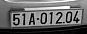

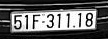

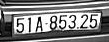

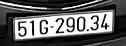

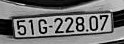

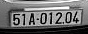

In [ ]:
import glob
from IPython.display import Image, display
count = 0
for imageName in glob.glob('/content/drive/MyDrive/capstone/voc_plate_dataset/yolov5/runs/detect/exp2/crops/plate/*.jpg'):
  if count <6: 
    count+=1
    display(Image(filename=imageName))
    print("\n")
  else:
    break

#EasyOCR for Optical Character Recognition

In [27]:
!pip install easyocr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.9 MB 5.2 MB/s 
     |████████████████████████████████| 604 kB 49.9 MB/s 
     |████████████████████████████████| 47.6 MB 87 kB/s 
     |████████████████████████████████| 120 kB 64.3 MB/s 
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.6.0.66
    Uninstalling opencv-python-headless-4.6.0.66:
      Successfully uninstalled opencv-python-headless-4.6.0.66


In [28]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from skimage.filters import threshold_local
from PIL import Image

In [29]:
import easyocr
import cv2
from matplotlib import pyplot as plt
import numpy as np
from google.colab.patches import cv2_imshow

In [ ]:
#Detecting number plate on custom data
%cd /content/drive/MyDrive/capstone/voc_plate_dataset/yolov5/
!python detect.py --weights /content/drive/MyDrive/capstone/voc_plate_dataset/yolov5/runs/train/yolov5s_results4/weights/best.pt --img 416 --conf 0.4 --source /content/drive/MyDrive/capstone/voc_plate_dataset/yolov5/runs/detect/exp2/crops/plate/CarLongPlate109.jpg --save-crop

/content/drive/MyDrive/capstone/voc_plate_dataset/yolov5
detect: weights=['/content/drive/MyDrive/capstone/voc_plate_dataset/yolov5/runs/train/yolov5s_results4/weights/best.pt'], source=/content/drive/MyDrive/capstone/voc_plate_dataset/yolov5/runs/detect/exp2/crops/plate/CarLongPlate109.jpg, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=True, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v6.2-203-g6371de8 Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
custom_YOLOv5m summary: 182 layers, 7246518 parameters, 0 gradients
image 1/1 /content/drive/MyDrive/capstone/voc_plate_dataset/yolov5/runs/detect/exp2/crops/plate/CarLongPlate109.jpg: 192x416 (no detections

In [ ]:
image1 = '/content/drive/MyDrive/capstone/voc_plate_dataset/yolov5/runs/detect/exp9/test.jpg'

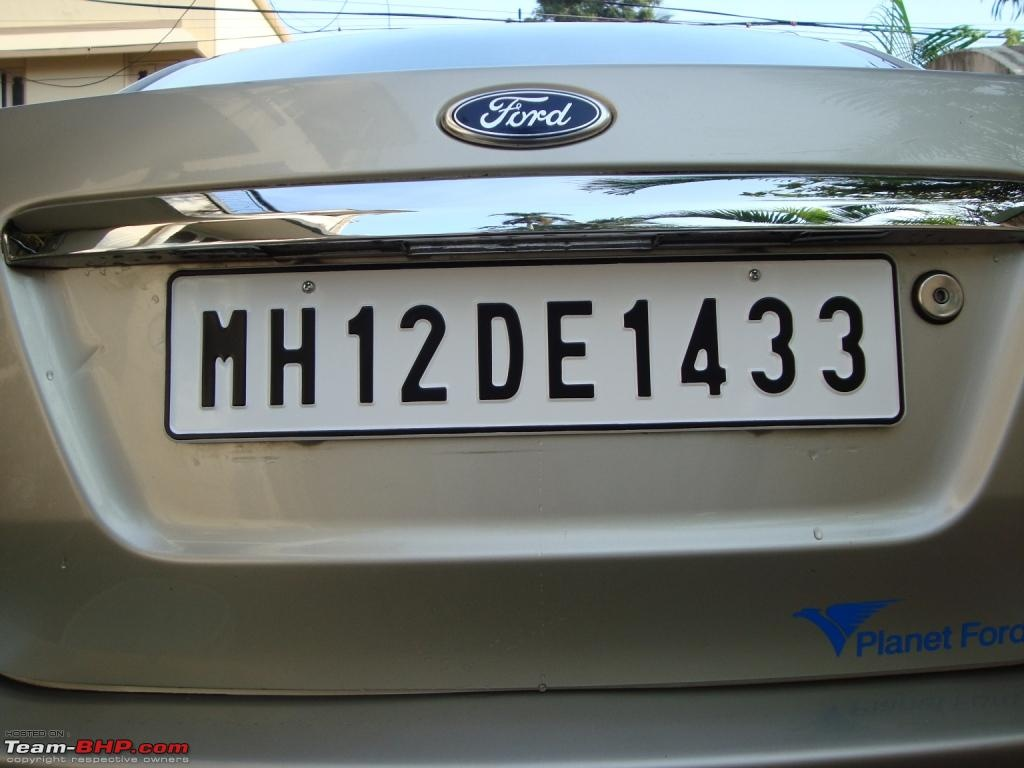

In [ ]:
img = cv2.imread(image1)
cv2_imshow(img)

In [ ]:
reader = easyocr.Reader(['en'])
result = reader.readtext(image1)
result

[([[475, 93], [577, 93], [577, 133], [475, 133]], 'Girrd', 0.4787029139650787),
 ([[184, 275], [883, 275], [883, 424], [184, 424]],
  'MHI2DE1433',
  0.5801023916511445),
 ([[849, 619], [1024, 619], [1024, 663], [849, 663]],
  'Planet Forc',
  0.9977575099095034),
 ([[11, 727], [67, 727], [67, 739], [11, 739]],
  'SETED@N',
  0.15207816726426326),
 ([[3, 736], [192, 736], [192, 760], [3, 760]],
  'Team-BHPcom',
  0.20736832751000545)]

In [ ]:
print(result[1][1])

MHI2DE1433


#TfLite with Image Extraction

In [ ]:
# Convert weights to fp16 TFLite model

!python export.py --weights /content/drive/MyDrive/capstone/voc_plate_dataset/yolov5/runs/train/yolov5s_results4/weights/best.pt --include tflite --img 416

export: data=data/coco128.yaml, weights=['/content/drive/MyDrive/capstone/voc_plate_dataset/yolov5/runs/train/yolov5s_results4/weights/best.pt'], imgsz=[416], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=12, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['tflite']
YOLOv5 🚀 v6.2-203-g6371de8 Python-3.7.15 torch-1.12.1+cu113 CPU

Fusing layers... 
custom_YOLOv5m summary: 182 layers, 7246518 parameters, 0 gradients

PyTorch: starting from /content/drive/MyDrive/capstone/voc_plate_dataset/yolov5/runs/train/yolov5s_results4/weights/best.pt with output shape (1, 10647, 6) (14.1 MB)

TensorFlow SavedModel: starting export with tensorflow 2.9.2...

                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.Focus               

In [ ]:
!python detect.py --weights /content/drive/MyDrive/capstone/voc_plate_dataset/yolov5/runs/train/yolov5s_results4/weights/best-fp16.tflite --img 416 --conf 0.25 --source /content/drive/MyDrive/capstone/voc_plate_dataset/yolov5/runs/detect/exp6/test.jpg --save-crop

detect: weights=['/content/drive/MyDrive/capstone/voc_plate_dataset/yolov5/runs/train/yolov5s_results4/weights/best-fp16.tflite'], source=/content/drive/MyDrive/capstone/voc_plate_dataset/yolov5/runs/detect/exp6/test.jpg, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=True, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v6.2-203-g6371de8 Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Loading /content/drive/MyDrive/capstone/voc_plate_dataset/yolov5/runs/train/yolov5s_results4/weights/best-fp16.tflite for TensorFlow Lite inference...
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
image 1/1 /content/drive/MyDrive/capstone/voc_plate_dataset/yolov5/runs/detect/exp6/test

In [ ]:
image2 = '/content/drive/MyDrive/capstone/voc_plate_dataset/yolov5/runs/detect/exp6/test.jpg'
img = cv2.imread(image2)
cv2_imshow(img)

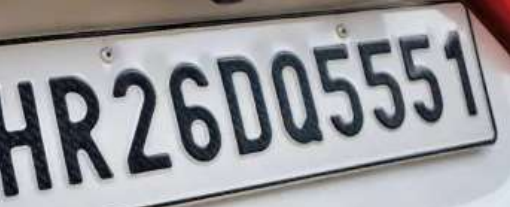

#Description

**License Plate Detection and Recognition**

Object detection is a phenomenon in computer vision that involves the detection of various objects in digital images or videos.

Object detection consists of various approaches such as fast R-CNN, Retina-Net, and Single-Shot MultiBox Detector (SSD). Although these approaches have solved the challenges of data limitation and modeling in object detection, they are not able to detect objects in a single algorithm run. YOLO algorithm has gained popularity because of its superior performance over the aforementioned object detection techniques.

Usage of yolov5 algorithm here, for object detection was done after comparing between SSD, YOLO and Retinanet.

YOLO stands for YOU ONLY LOOK ONCE, and is an algorithm that detects and recognizes various objects in a picture in real-time.YOLO algorithm employs convolutional neural networks (CNN) to detect objects in real-time. As the name suggests, the algorithm requires only a single forward propagation through a neural network to detect objects.

This means that prediction in the entire image is done in a single algorithm run. The CNN is used to predict various class probabilities and bounding boxes simultaneously.



Converting images to grayscale is important to simplify the algorithm and reduce computational requirements. As color, increases the complexity of the model, providing with unnecessary information. But the gray-scale images reduce the overall computation time and noise.

The YAML files are equipped to represent data specifically. Here in this project, we used two yaml files in training the yolo model, first one to specify the locations of training data and its path, then also the number of classes that we wish the model to detect and the second yaml is to specify the whole model.

Then the trained yolov5 detector's performance is evaluated using tensorboard, and then visualization is done on the training data and predicted label data. And hence, the object is detected using detect.py(training is done using train.py)

EasyOCR is a python package that allows the image to be converted to text. Optical Character Reader or Optical Character Recognition (OCR) is a technique used to convert the text in visuals to machine-encoded text. EasyOCR allows computer vision developers to efffortlessly perform optical character recognition.

TFLite or the TensorFlow Lite Model Maker library is a high-level library that simplifies the process of training a TensorFlow Lite model using a custom dataset. It uses transfer learning to reduce the amount of training data required and shorten the training time.